In [1]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import RidgeCV
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess
import holidays

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")

In [52]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "release_post", "days_since_previous_release"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df[df["release_post"] == True].copy()

In [53]:
df.head()

,post_month,day,year,release_post,days_since_previous_release,month,date
id,,,,,,,
183,February,17,2017,True,0.0,2,2017-02-17
197,February,26,2017,True,9.0,2,2017-02-26
109,March,18,2017,True,20.0,3,2017-03-18
57,March,24,2017,True,6.0,3,2017-03-24
196,March,30,2017,True,6.0,3,2017-03-30


In [54]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})

In [55]:
df = df.groupby(["month", "year"]).agg(
    {c : ("mean" if c == "days_since_previous_release" else "sum") for c in df.columns 
     if c == "release_post" or c == "days_since_previous_release"}).reset_index().rename(
    columns={"release_post" : "number_of_releases", "days_since_previous_release" : "avg_days_between_releases"})
df["day"] = 1
df["date"] = pandas.to_datetime(df[["year", "day", "month"]])
df = df.set_index("date")
df.index = df.index.to_period("M")

In [56]:
df["holidays"] = df.apply(
    lambda x : len([h for h in nj_holidays if h.month == x["month"] and h.year == x["year"]]), axis=1)

In [57]:
del df["month"]
del df["day"]
del df["year"]
df = df.sort_index()
df.head()

,number_of_releases,avg_days_between_releases,holidays
date,,,
2017-02,2,4.500000,4
2017-03,3,10.666667,1
2017-04,4,5.250000,1
2017-05,3,9.333333,1
2017-06,5,7.000000,0


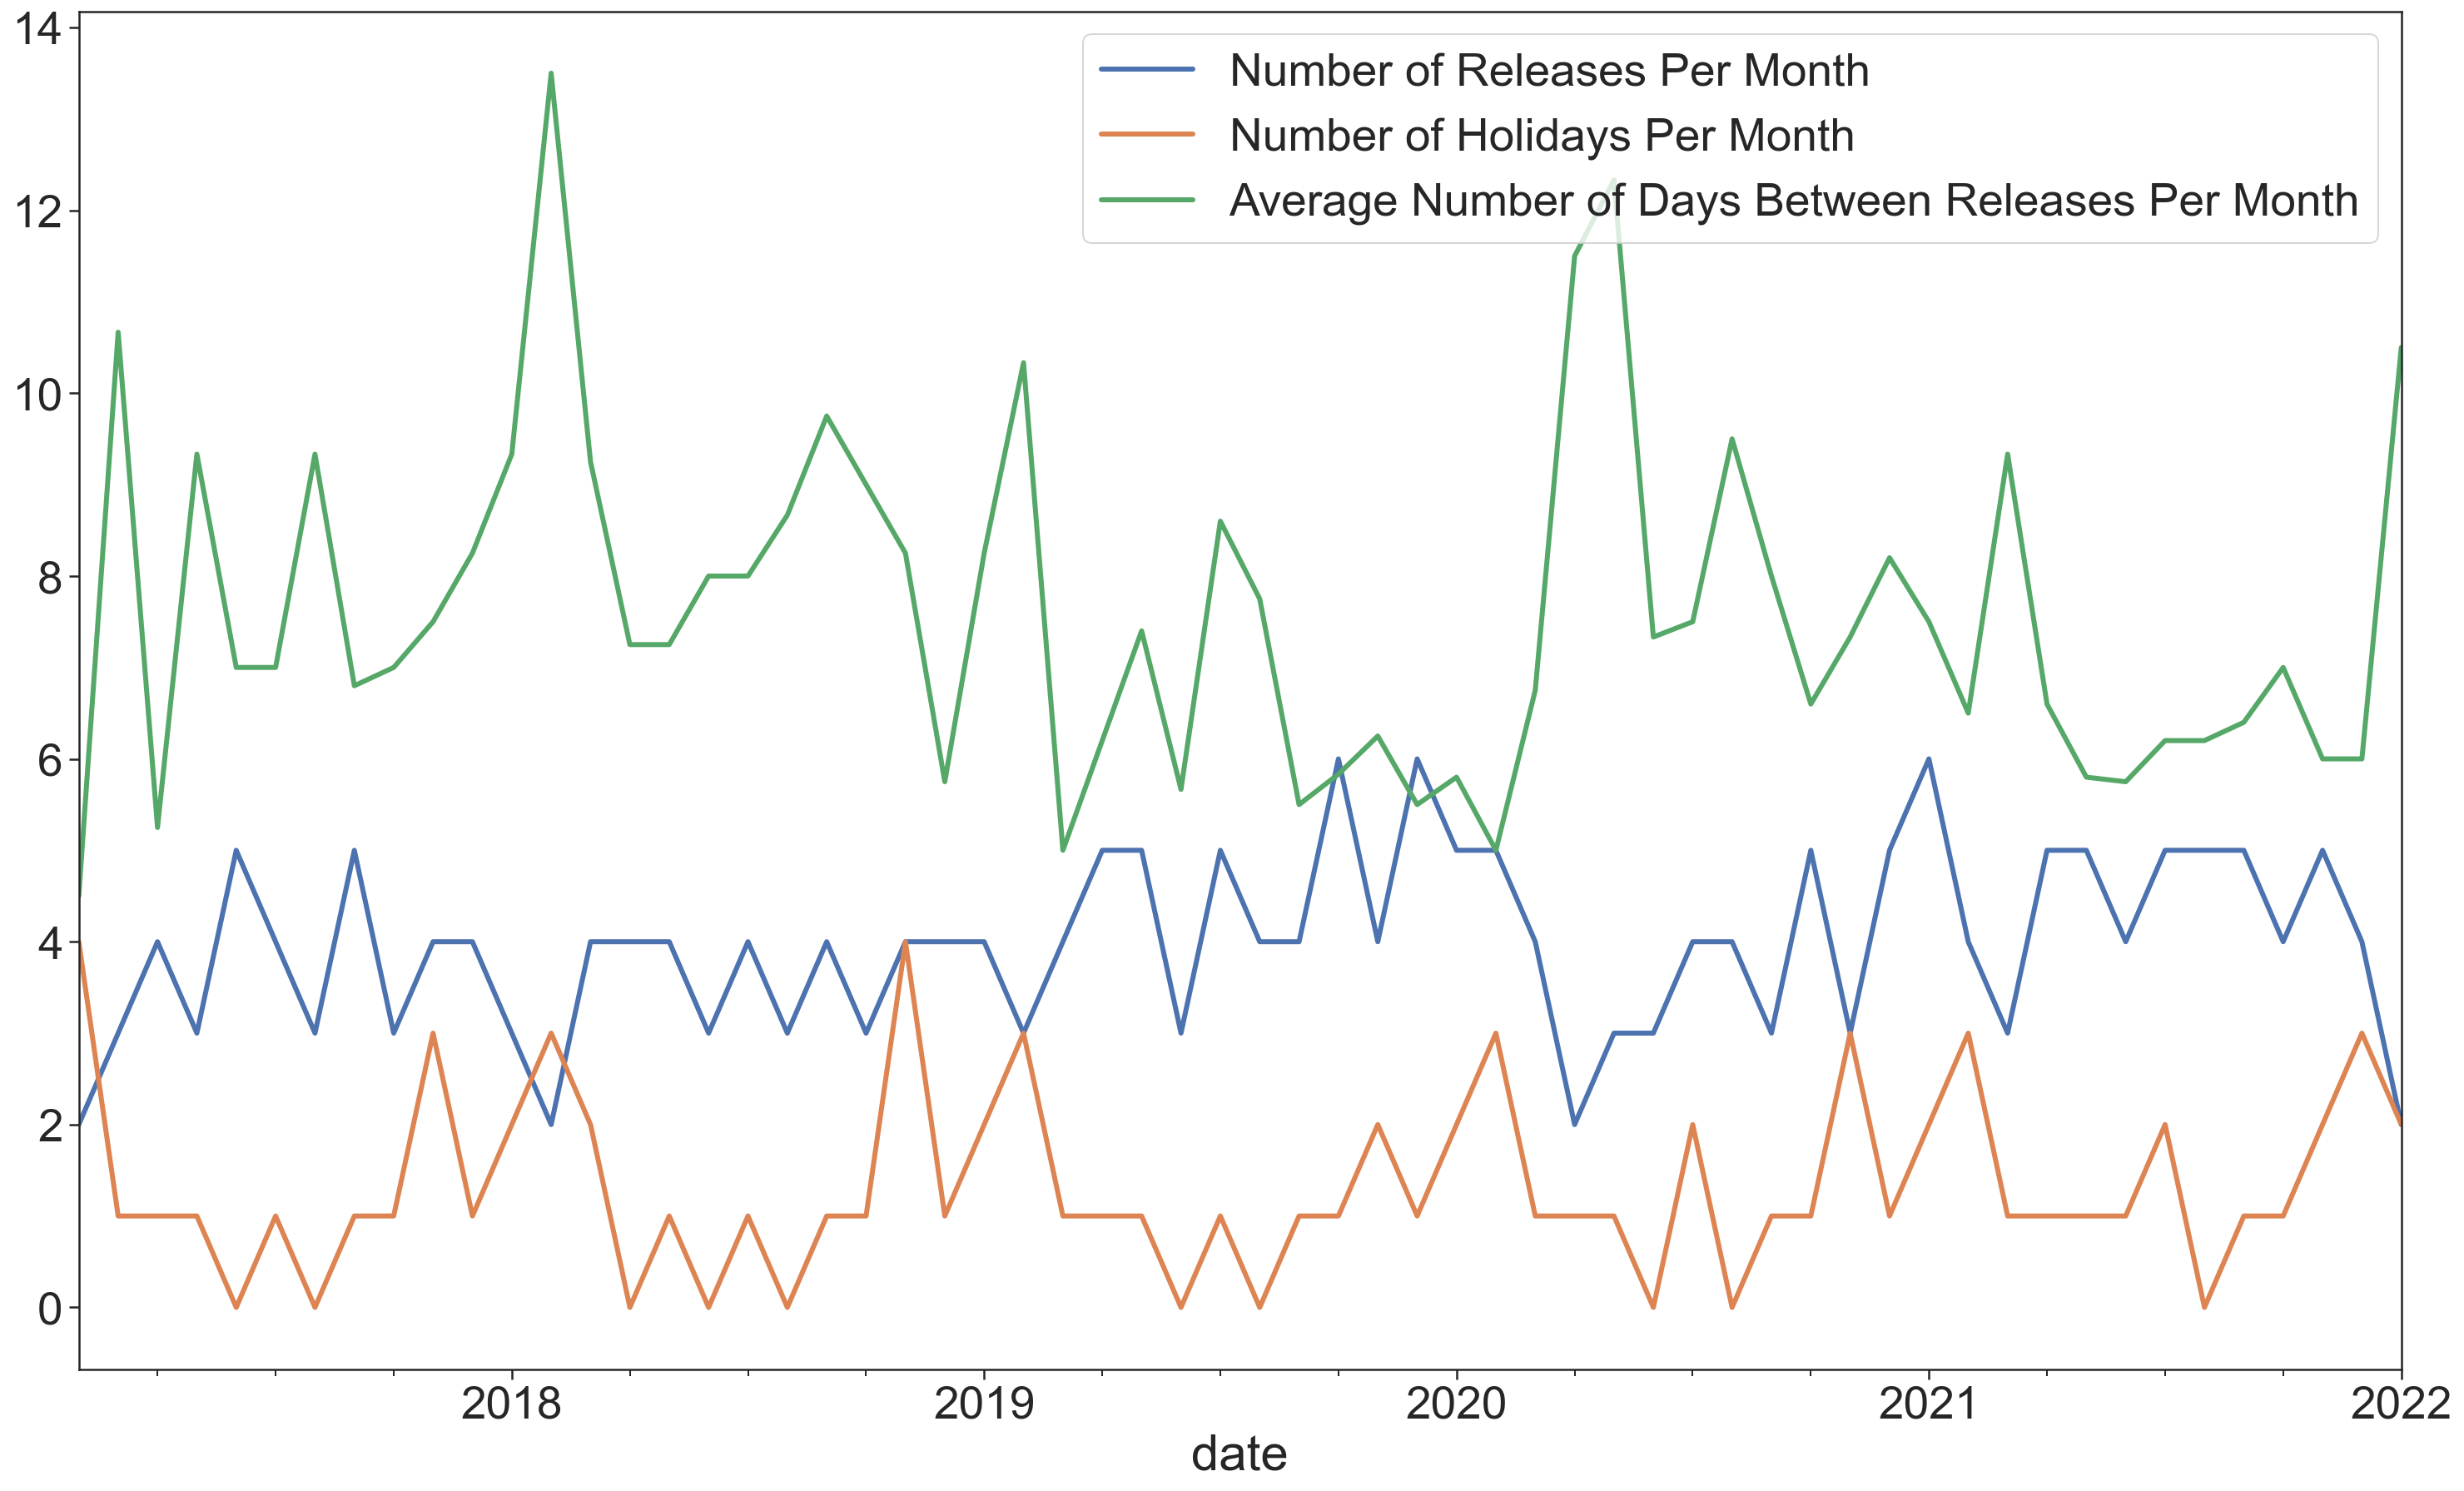

In [58]:
ax = df["number_of_releases"].plot(linewidth=3)
df["holidays"].plot(ax=ax, linewidth=3)
df["avg_days_between_releases"].plot(ax=ax, linewidth=3)
ax.legend(["Number of Releases Per Month", "Number of Holidays Per Month",
           "Average Number of Days Between Releases Per Month"])
plt.show()

<AxesSubplot:xlabel='date'>

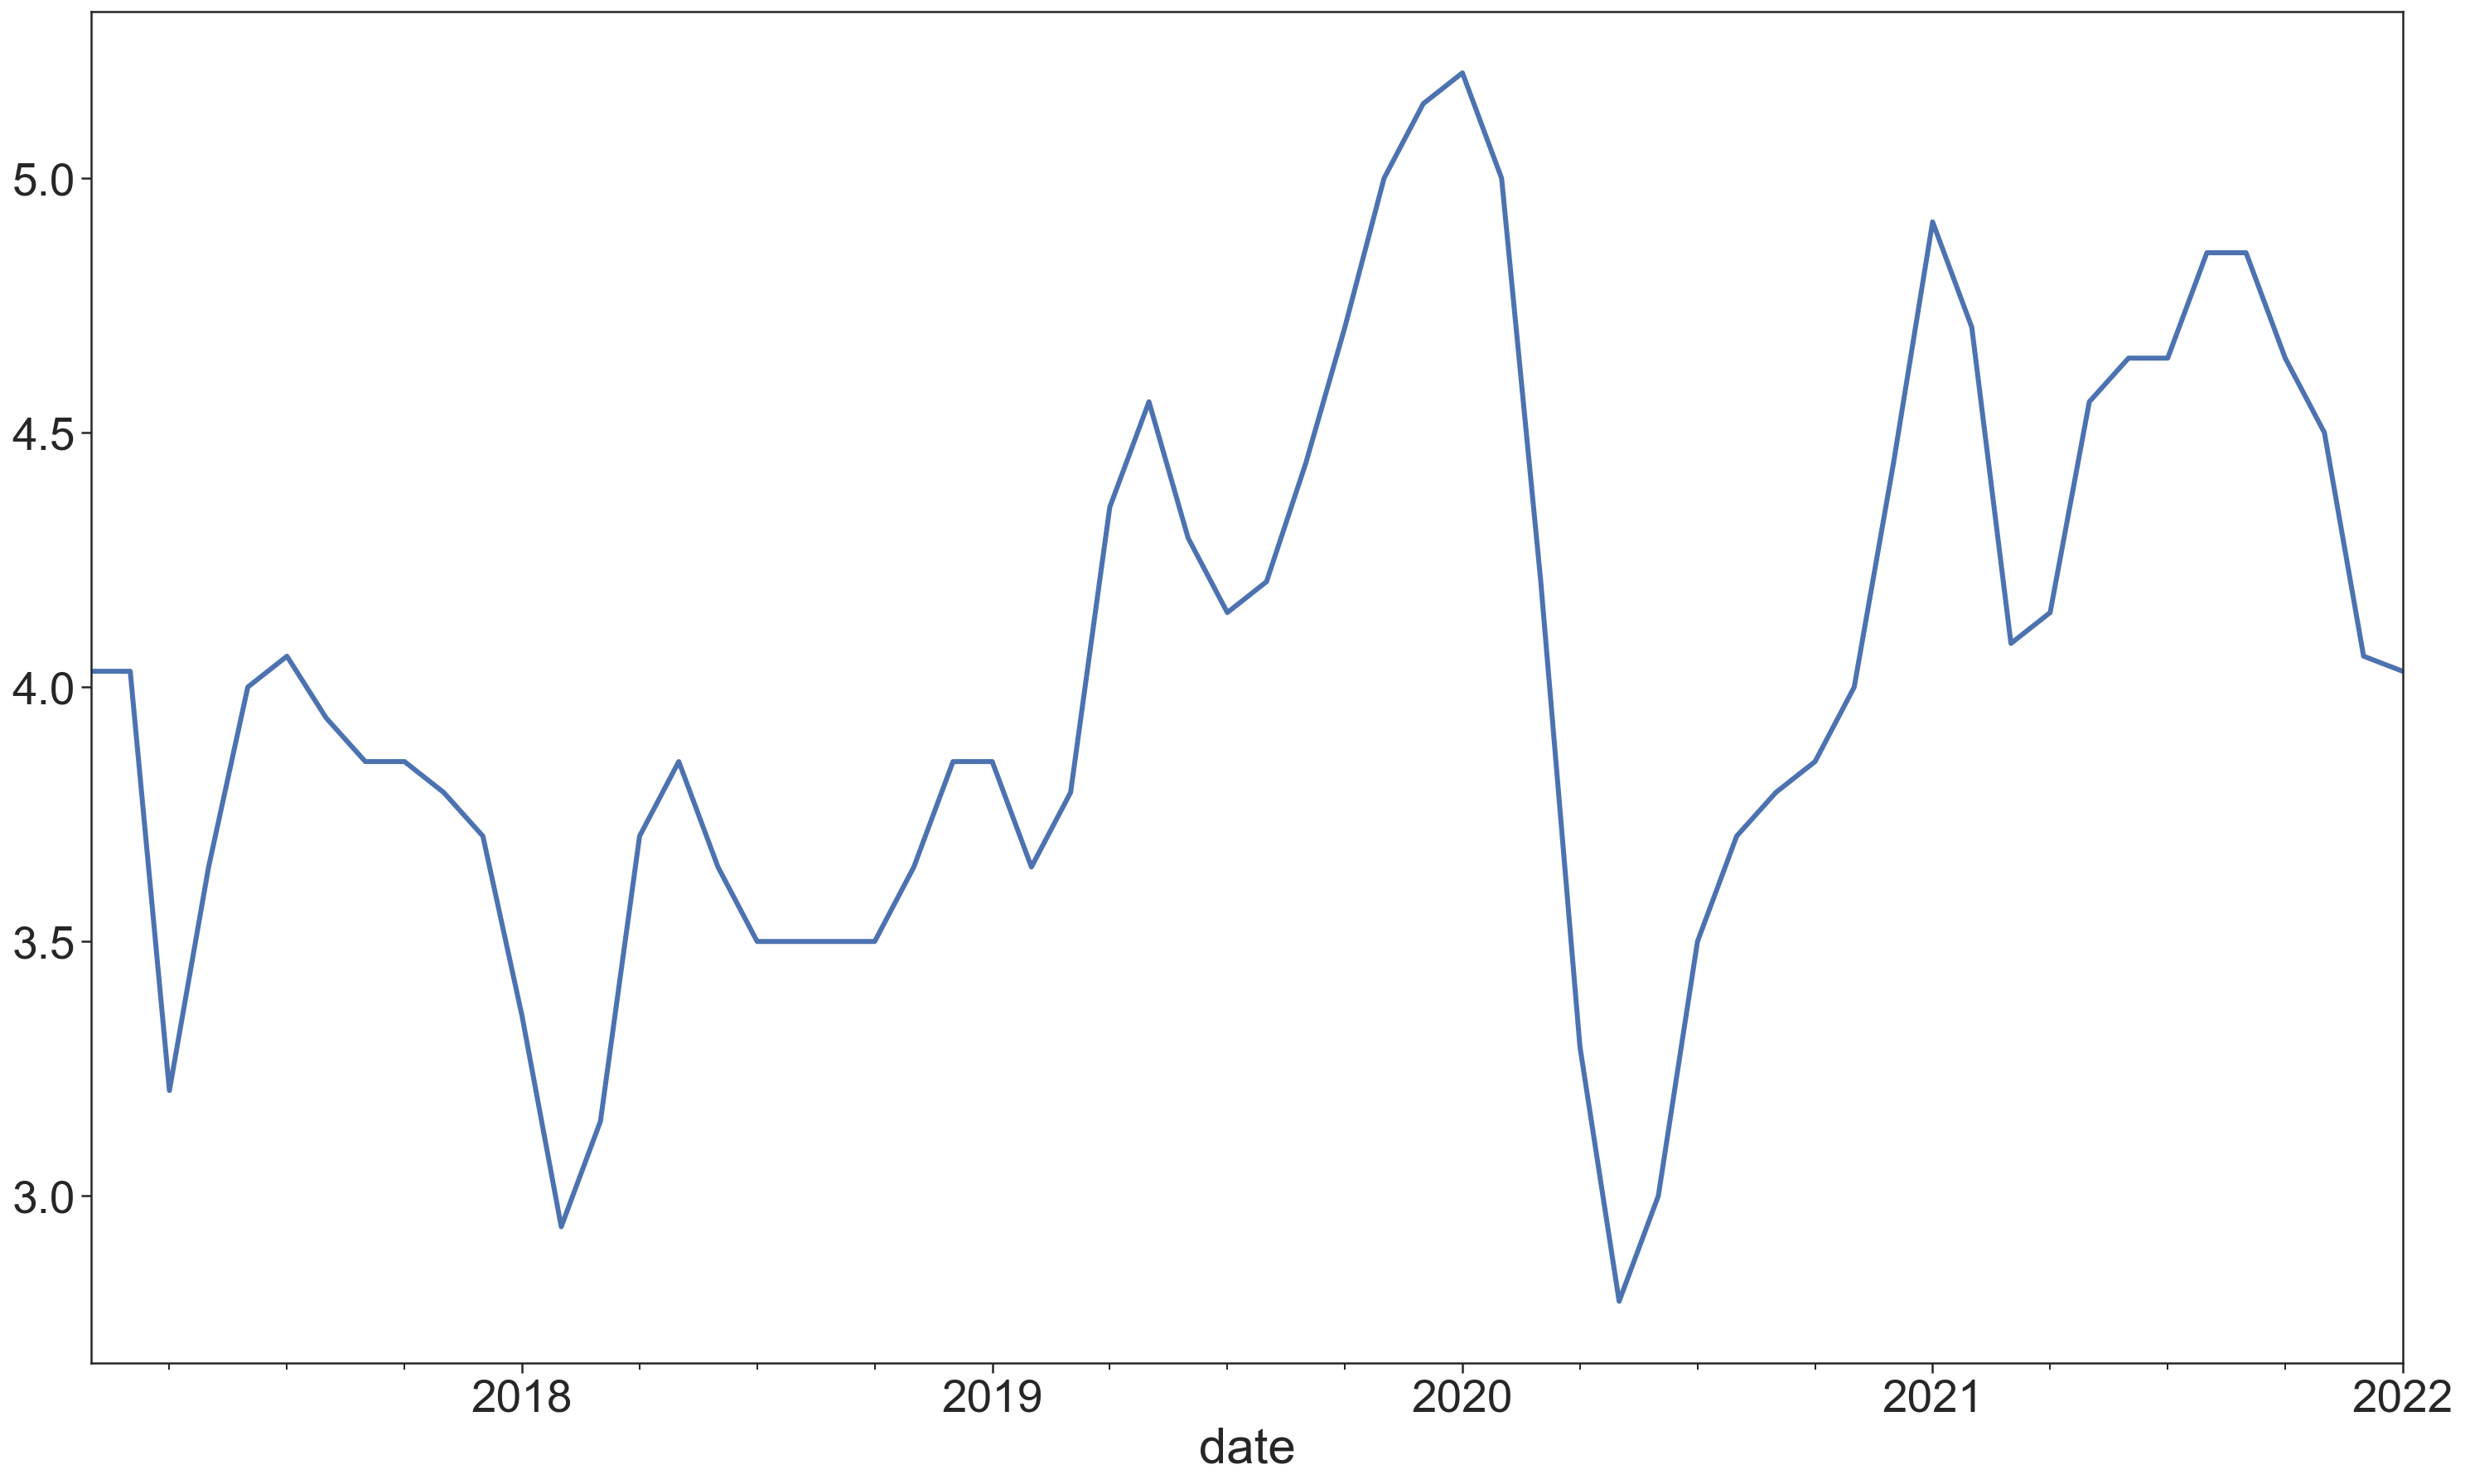

In [59]:
temp = df.rolling(window=4, center=True, win_type="cosine").mean()[["number_of_releases"]]
temp = temp.rename(columns={"number_of_releases" : "quarterly_cosine"})
df = df.join(temp)
df["quarterly_cosine"] = df["quarterly_cosine"].fillna(df["quarterly_cosine"].mean())
df["quarterly_cosine"].plot(linewidth=3)

In [60]:
df["releases_lag_1"] = df["number_of_releases"].shift(1).fillna(0)

In [61]:
df["month"] = df.index.month
df = pandas.get_dummies(df, columns=["month"], prefix="month")

In [14]:
# dp = DeterministicProcess(df.index, order=2, seasonal=False, fourier=1, drop=True)
# df = df.join(dp.in_sample())

In [62]:
df[[c for c in df.columns if not c.startswith("month_")]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
avg_days_between_releases,-0.550656
holidays,-0.108024
quarterly_cosine,0.629900
releases_lag_1,0.233899


In [64]:
df[[c for c in df.columns if c == "number_of_releases" or c.startswith("month_")]].corr()[["number_of_releases"]]

,number_of_releases
number_of_releases,1.000000
month_1,0.010228
month_2,-0.235246
month_3,-0.112509
month_4,0.010228
month_5,0.010228
month_6,-0.112509
month_7,0.132965
month_8,-0.051140
month_9,0.071597


In [65]:
training_size = int(round(len(df) * 0.85, 0))
training_size

51

In [66]:
train_df = df[0:training_size].copy()
len(train_df)

51

In [67]:
test_df = df[training_size:].copy()
len(test_df)

9

In [68]:
df.columns

Index(['number_of_releases', 'avg_days_between_releases', 'holidays',
       'quarterly_cosine', 'releases_lag_1', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [69]:
features = (['quarterly_cosine', 'releases_lag_1', 'holidays', 'avg_days_between_releases']
            + [c for c in df.columns if c.startswith("month_")])

---

In [70]:
reg = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
              scoring="neg_mean_absolute_percentage_error",
              cv=2)
reg.fit(train_df[features], train_df["number_of_releases"])

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), cv=2,
        scoring='neg_mean_absolute_percentage_error')

In [71]:
reg.best_score_

-0.21372877486725866

In [72]:
test_df["predicted"] = reg.predict(test_df[features]).round(0)

In [73]:
mape(test_df["number_of_releases"], test_df["predicted"])

0.13333333333333333

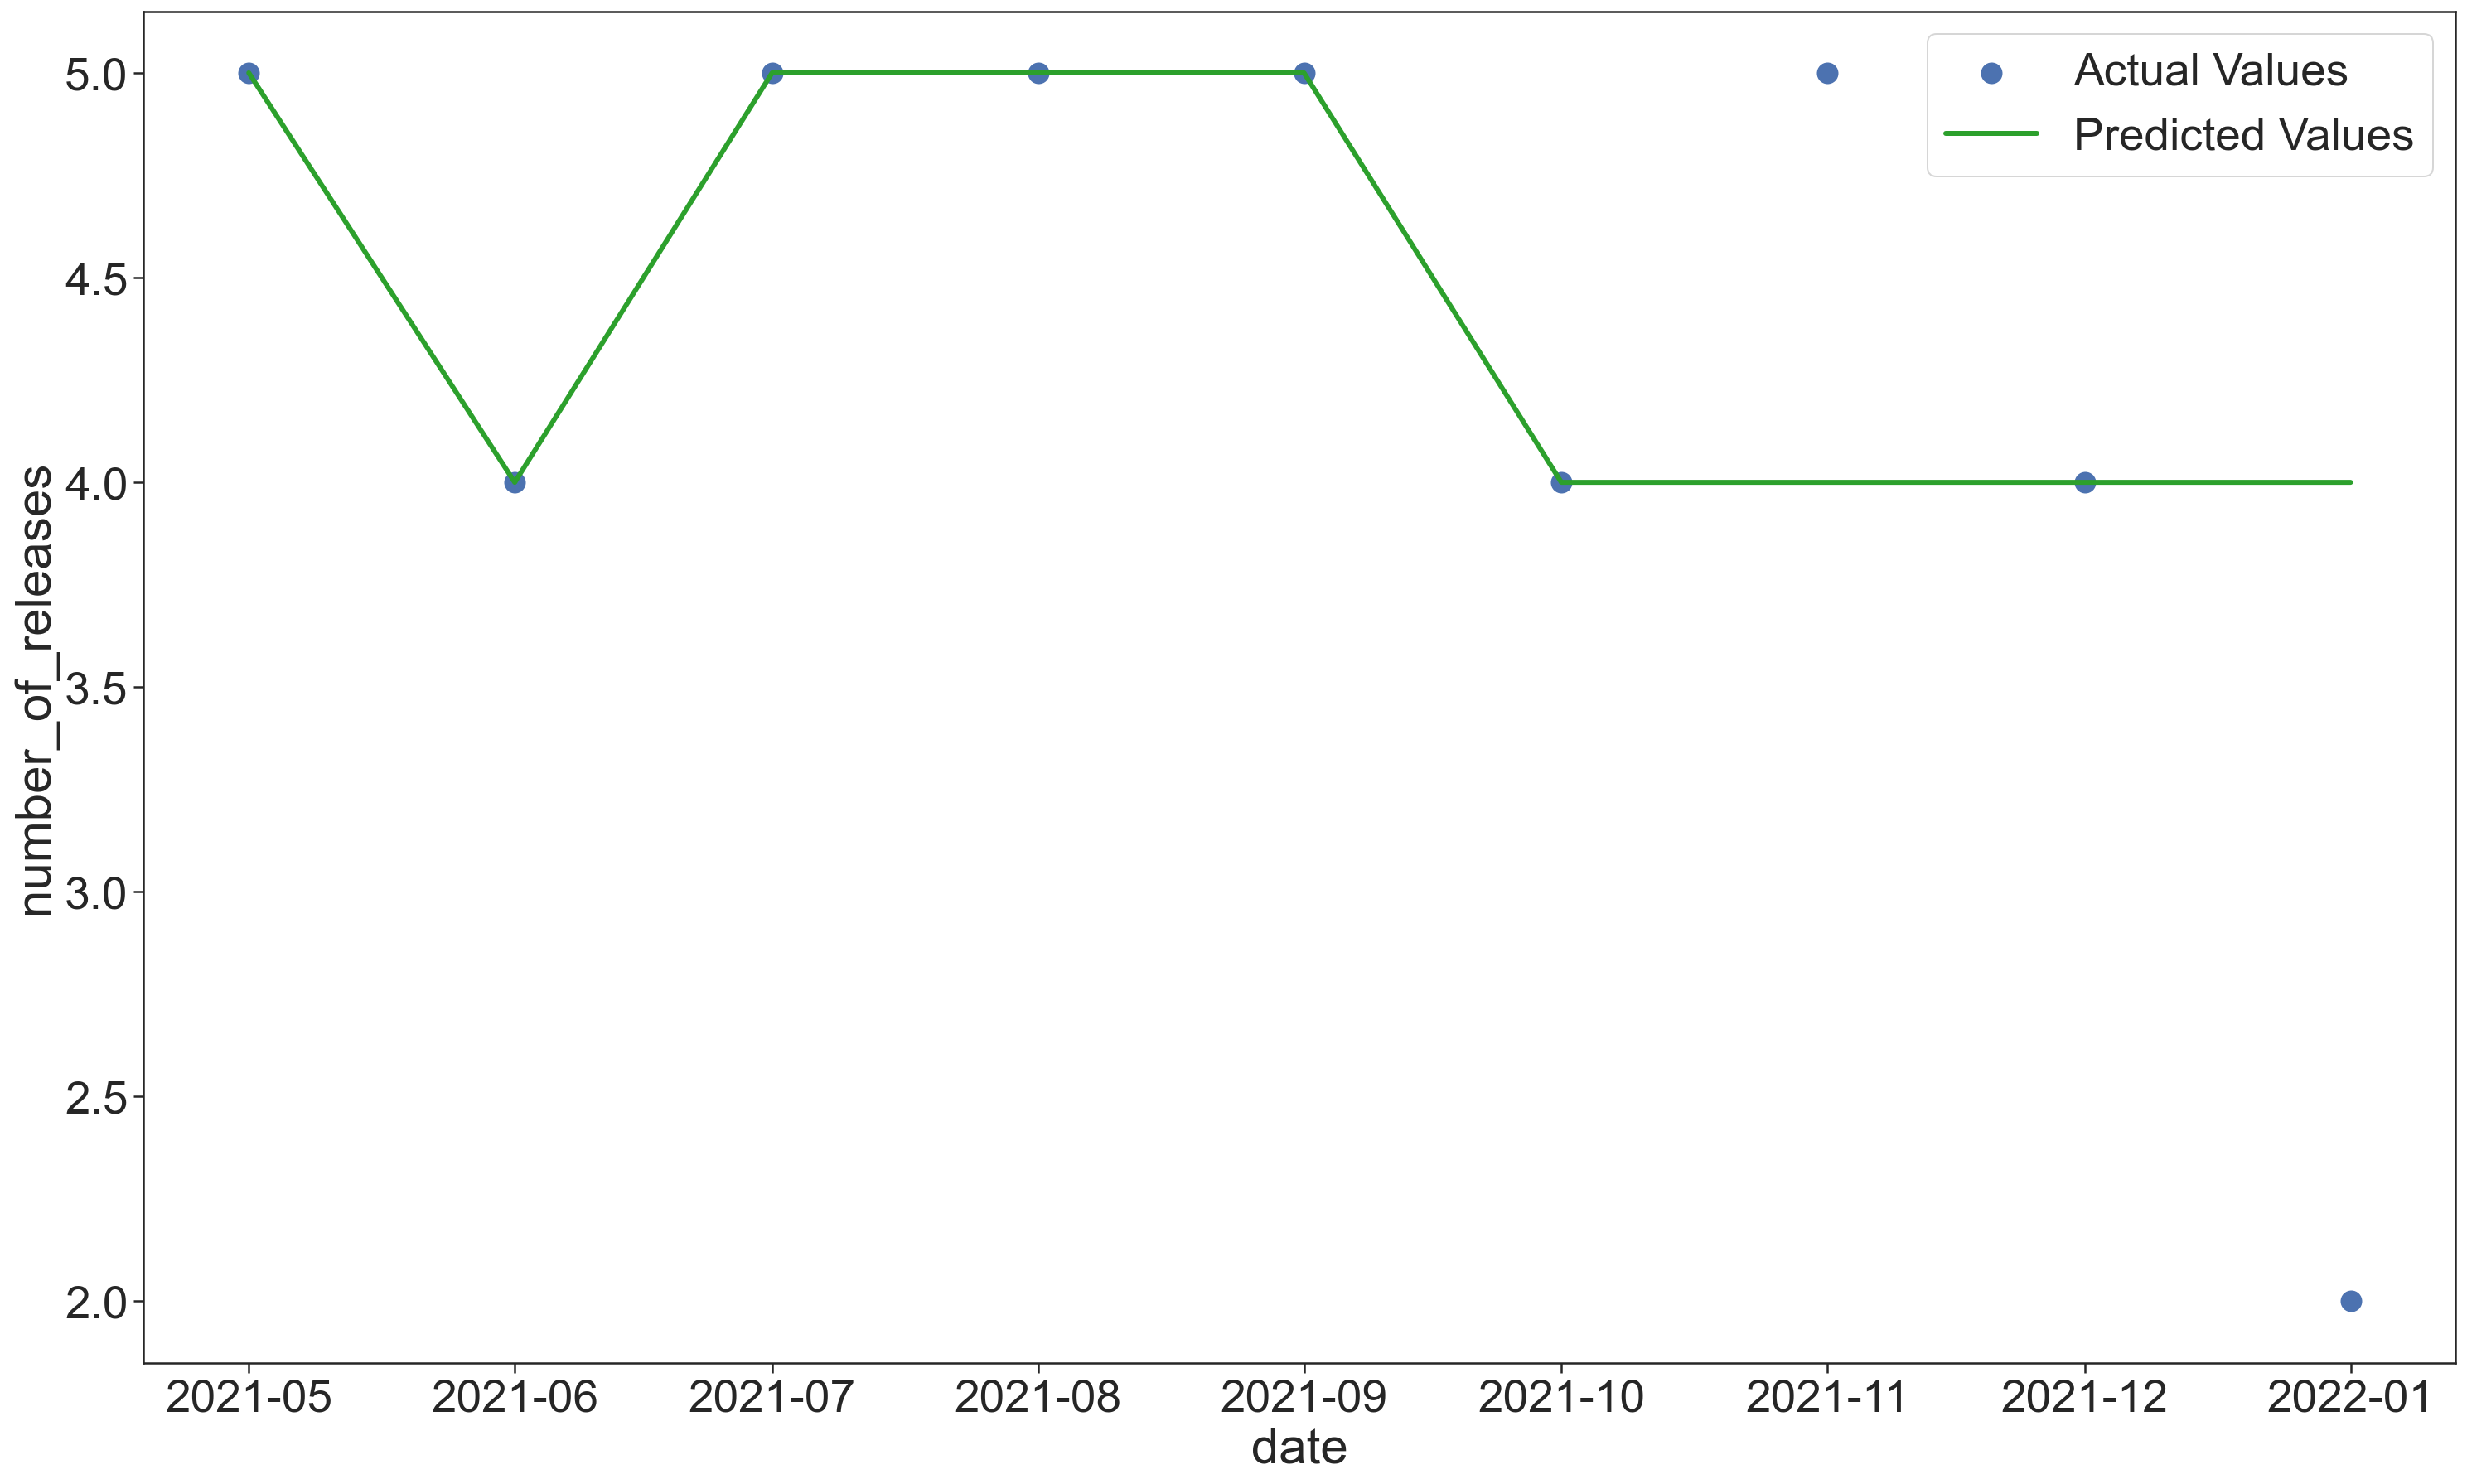

In [77]:
ax = sns.scatterplot(x=test_df.index.to_timestamp(), y=test_df["number_of_releases"], s=200)
sns.lineplot(x=test_df.index.to_timestamp(), y=test_df["predicted"], linewidth=3, ax=ax, color="tab:green")
ax.legend(["Actual Values", "Predicted Values"])
plt.show()

In [76]:
list(zip(features, reg.coef_))

[('quarterly_cosine', 0.48572628885959945),
 ('releases_lag_1', -0.02808868997228047),
 ('holidays', -0.08900106128272846),
 ('avg_days_between_releases', -0.16469866273144707),
 ('month_1', 0.13964947216553236),
 ('month_2', -0.18879738303869847),
 ('month_3', -0.07138731796794466),
 ('month_4', 0.02571751914902822),
 ('month_5', 0.04169339812555768),
 ('month_6', -0.15597923412423642),
 ('month_7', 0.1152651246304245),
 ('month_8', -0.08104721495989682),
 ('month_9', 0.011988744534699312),
 ('month_10', 0.05701651977743217),
 ('month_11', -0.04060788419401025),
 ('month_12', 0.14648825590211234)]